In this notebook, we play around with the DCT and plot some of the associated information that might be interesting.

In [2]:
%load_ext autoreload
%autoreload 2
from geolifeclef.utils import get_spark

# disable vectorization
spark = get_spark(
    memory="22g",
    **{
        "spark.sql.parquet.enableVectorizedReader": False,
        "spark.sql.shuffle.partitions": 300,
    },
)
spark

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
df = spark.read.parquet(
    "gs://dsgt-clef-geolifeclef-2024/data/processed/sample_tiles/random_v1"
)
df.printSchema()
df.count()

root
 |-- bio1: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- bio2: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- HFP2009_WGS84: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- red: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- green: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- blue: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- nir: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- surveyId: double (nullable = true)
 |-- target: long (nullable = true)



10000

In [4]:
pdf = df.limit(10).toPandas()
pdf.columns

Index(['bio1', 'bio2', 'HFP2009_WGS84', 'red', 'green', 'blue', 'nir', 'lat',
       'lon', 'surveyId', 'target'],
      dtype='object')

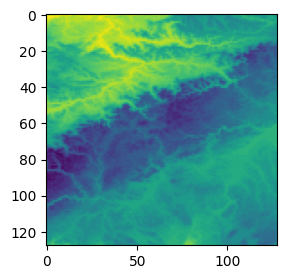

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# plot a tile just to make sure its well-formed
tile = pdf.iloc[0].bio1
plt.figure(figsize=(3, 3))
plt.imshow(np.array(tile).reshape(128, 128))
plt.show()

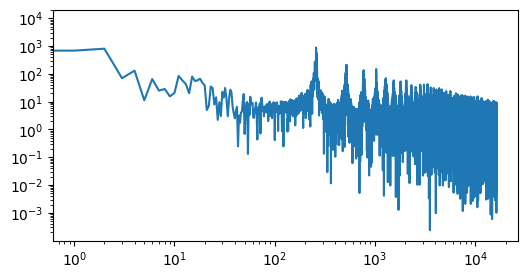

In [6]:
# run the dct and show bode plot
from scipy.fftpack import dct

coeff = dct(tile)
plt.figure(figsize=(6, 3))
plt.plot(range(len(coeff)), np.abs(coeff))
plt.xscale("log")
plt.yscale("log")
plt.show()

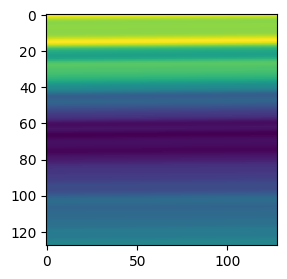

In [7]:
# let's keep the first 50 coefficients and see how it looks
coeff[50:] = 0
reconstructed = dct(coeff, type=3)
plt.figure(figsize=(3, 3))
plt.imshow(np.array(reconstructed).reshape(128, 128))

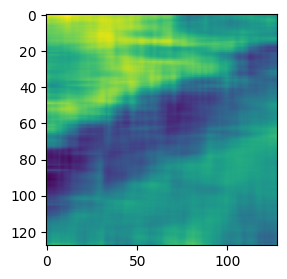

In [8]:
# instead, lets run the 2d dct
from scipy.fftpack import dctn

tile2d = np.array(tile).reshape(128, 128)
coeff = dctn(tile2d)
# keep the first k coefficients
k = 8
coeff[k:, k:] = 0
reconstructed = dctn(coeff, type=3)
plt.figure(figsize=(3, 3))
plt.imshow(reconstructed)
plt.show()

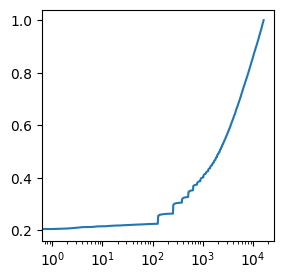

In [9]:
# calculate cumulative energy retained by the first k coefficients, and find the point where it reaches 80%
coeff = dctn(tile2d)
# use the norm of the coefficients
total_energy = np.sum(np.abs(coeff))
cumulative_energy = np.cumsum(np.abs(coeff))
cumulative_energy /= total_energy
plt.figure(figsize=(3, 3))
plt.plot(range(len(cumulative_energy)), cumulative_energy)
plt.xscale("log")
plt.show()

In [10]:
from geolifeclef.functions import dctn_filter_udf

df.limit(10).select(
    dctn_filter_udf("bio1").alias("bio1_dct8"),
).show()

+--------------------+
|           bio1_dct8|
+--------------------+
|[-17072.574, 375....|
|[-6051.473, 691.0...|
|[-1069.3806, 184....|
|[-63979.77, -4599...|
|[-39095.05, 10479...|
|[-22771.396, 307....|
|[-27252.111, -232...|
|[17365.432, -2477...|
|[-8219.134, 2249....|
|[-4320.579, 550.6...|
+--------------------+



In [11]:
train_df = spark.read.parquet(
    "gs://dsgt-clef-geolifeclef-2024/data/processed/sample_tiles/species_v1"
)
train_df.printSchema()
train_df.count()

root
 |-- target: long (nullable = true)
 |-- bio1: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- bio2: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- HFP2009_WGS84: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- red: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- green: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- blue: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- nir: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- surveyId: double (nullable = true)



73568

In [12]:
train_df.groupBy("target").count().show()

+------+-----+
|target|count|
+------+-----+
|  3958| 7353|
| 11054| 6427|
|  1757| 9265|
| 10247| 7745|
|  2885| 8764|
|  8208| 7058|
|  9816| 6835|
|   540| 6439|
| 10047| 7152|
|  2474| 6530|
+------+-----+



In [13]:
# let's take an even smaller sample of these data points just to get a rough sense of modeling
# sample by target
subset_df = (
    train_df.sampleBy(
        "target",
        fractions={
            x: 0.1 for x in train_df.select("target").distinct().toPandas()["target"]
        },
    )
    .repartition(200)
    .cache()
)
subset_df.groupBy("target").count().show()

+------+-----+
|target|count|
+------+-----+
|  3958|  748|
| 11054|  668|
|  1757|  948|
| 10247|  821|
|  2885|  843|
|  8208|  727|
|  9816|  728|
|   540|  581|
| 10047|  716|
|  2474|  663|
+------+-----+



In [23]:
# let's build some models and do some comparisons

# how good is this data for predicting species?
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


def baseline_pipeline(features=["lat", "lon"], target="target"):
    assembler = VectorAssembler(
        inputCols=features,
        outputCol="features",
    )
    scaler = StandardScaler(
        inputCol=assembler.getOutputCol(),
        outputCol="scaled_features",
        withStd=True,
        withMean=True,
    )
    lr = LogisticRegression(
        labelCol=target,
        featuresCol=scaler.getOutputCol(),
        regParam=0.3,
        elasticNetParam=0.8,
    )
    return Pipeline(stages=[assembler, scaler, lr])


def evaluate_model(model, df, seed=42):
    train, test = df.randomSplit([0.8, 0.2], seed=seed)
    model = model.fit(train)
    predictions = model.transform(test)
    accuracy_evaluator = MulticlassClassificationEvaluator(
        labelCol="target", predictionCol="prediction", metricName="accuracy"
    )
    f1_evaluator = MulticlassClassificationEvaluator(
        labelCol="target", predictionCol="prediction", metricName="f1"
    )
    return {
        "accuracy": accuracy_evaluator.evaluate(predictions),
        "f1": f1_evaluator.evaluate(predictions),
    }


baseline_model = baseline_pipeline(features=["lat", "lon"])
# 13m
# evaluate_model(baseline_model, train_df)
# {'accuracy': 0.12762793213006152, 'f1': 0.028890538440328056}

In [24]:
# lets do this again, but on a cached subset
%time evaluate_model(baseline_model, subset_df)

CPU times: user 148 ms, sys: 12.9 ms, total: 160 ms
Wall time: 1min 37s


{'accuracy': 0.1351170568561873, 'f1': 0.032166936340541935}

In [16]:
# now let's try the same thing, but with dct features
from pyspark.ml.functions import array_to_vector

dct_df = train_df.select(
    *(
        [
            array_to_vector(dctn_filter_udf(col)).alias(f"{col}_dct8")
            for col in train_df.columns
            if col in ["red", "green", "blue", "nir", "bio1", "bio2", "HFP2009_WGS84"]
        ]
        + ["lat", "lon", "target"]
    )
).cache()
dct_df.printSchema()

root
 |-- bio1_dct8: vector (nullable = true)
 |-- bio2_dct8: vector (nullable = true)
 |-- HFP2009_WGS84_dct8: vector (nullable = true)
 |-- red_dct8: vector (nullable = true)
 |-- green_dct8: vector (nullable = true)
 |-- blue_dct8: vector (nullable = true)
 |-- nir_dct8: vector (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- target: long (nullable = true)



In [25]:
r_model = baseline_pipeline(["red_dct8"])
%time evaluate_model(r_model, dct_df)

In [ ]:
rgb_model = baseline_pipeline(["red_dct8", "green_dct8", "blue_dct8"])
%time evaluate_model(rgb_model, dct_df)

CPU times: user 1.96 s, sys: 655 ms, total: 2.61 s
Wall time: 29min 5s


{'accuracy': 0.11823159602514703, 'f1': 0.025001458281705018}

In [ ]:
nir_model = baseline_pipeline(["nir_dct8"])
%time evaluate_model(nir_model, dct_df)

CPU times: user 1.65 s, sys: 542 ms, total: 2.2 s
Wall time: 11min 17s


{'accuracy': 0.12505914959778275, 'f1': 0.02780261091821163}

In [20]:
bio_model = baseline_pipeline(["bio1_dct8", "bio2_dct8"])
%time evaluate_model(bio_model, dct_df)

CPU times: user 1.6 s, sys: 489 ms, total: 2.09 s
Wall time: 21min 58s


{'accuracy': 0.12505914959778275, 'f1': 0.02780261091821163}

In [21]:
hfp_model = baseline_pipeline(["HFP2009_WGS84_dct8"])
%time evaluate_model(hfp_model, dct_df)

CPU times: user 1.75 s, sys: 565 ms, total: 2.31 s
Wall time: 11min 1s


{'accuracy': 0.12505914959778275, 'f1': 0.02780261091821163}

In [22]:
all_model = baseline_pipeline(
    [
        "red_dct8",
        "green_dct8",
        "blue_dct8",
        "nir_dct8",
        "bio1_dct8",
        "bio2_dct8",
        "HFP2009_WGS84_dct8",
    ]
)
%time evaluate_model(all_model, dct_df)

CPU times: user 3.46 s, sys: 1 s, total: 4.46 s
Wall time: 1h 15min 44s


{'accuracy': 0.12505914959778275, 'f1': 0.02780261091821163}